In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('wild caught salmon photos', max_images=1)
urls

Searching for 'wild caught salmon photos'


(#1) ['https://cdn.shopify.com/s/files/1/2255/3255/products/Square__0000_fish_salmon_filet_ae1a80ff-16ed-4bd3-b858-ddf4d49eb067.jpg?v=1578809151']

In [6]:
from fastai.vision.all import *

searches = 'wild caught salmon','farm raised salmon'
path = Path('wild_caught_or_not')
path

/home/vscode/miniconda3/envs/deeplearning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path('wild_caught_or_not')

In [7]:
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sushi photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sashimi photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


Searching for 'wild caught salmon photo'
Searching for 'wild caught salmon sushi photo'
Searching for 'wild caught salmon sashimi photo'
Searching for 'farm raised salmon photo'
Searching for 'farm raised salmon sushi photo'
Searching for 'farm raised salmon sashimi photo'


0

/home/vscode/miniconda3/envs/deeplearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/vscode/miniconda3/envs/deeplearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/vscode/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 17.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.170756,0.965453,0.306452,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.714957,0.751253,0.225806,00:28
1,0.492403,0.595050,0.129032,00:27
2,0.395411,0.514087,0.161290,00:26


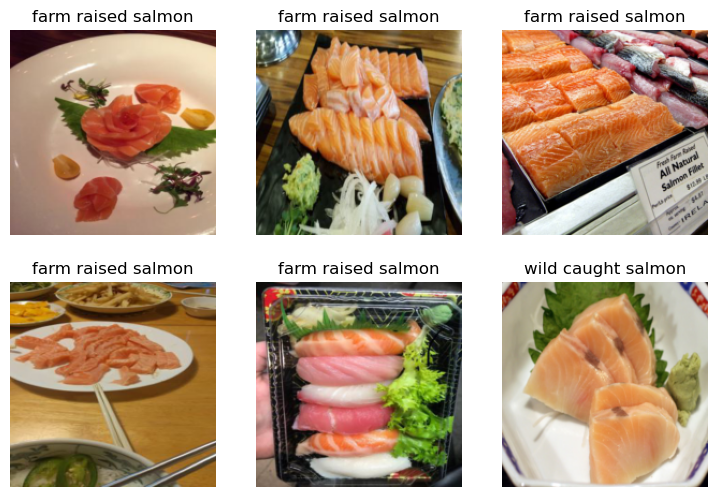

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

This is a: wild caught salmon.
Probability it's a wild caught salmon salmon: 0.0044


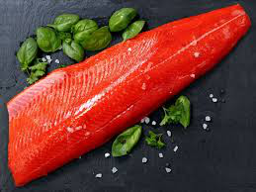

In [13]:
image_path = 'wild_caught_test.jpeg'
is_wild_or_farm,_,probs = learn.predict(PILImage.create(image_path))
print(f"This is a: {is_wild_or_farm}.")
print(f"Probability it's a {is_wild_or_farm} salmon: {probs[0]:.4f}")
Image.open(image_path).to_thumb(256,256)

This is a: wild caught salmon.
Probability it's a wild caught salmon salmon: 0.3164


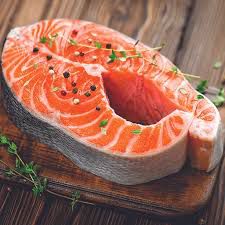

In [15]:
image_path = 'farm_raised_test2.jpeg'
Image.open(image_path).to_thumb(256,256)
is_wild_or_farm,_,probs = learn.predict(PILImage.create(image_path))
print(f"This is a: {is_wild_or_farm}.")
print(f"Probability it's a {is_wild_or_farm} salmon: {probs[0]:.4f}")
Image.open(image_path).to_thumb(256,256)